In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

from tqdm.notebook import tqdm

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold

In [3]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

In [4]:
import youtokentome as yttm

In [5]:
data_1 = pd.read_csv('data/SPAM text message 20170820 - Data.csv', index_col='Category').rename(columns={'Message':'text'},)
data_2 = pd.read_csv('data/spam.csv', index_col='v1')[['v2']].rename(columns={'v2':'text'})
data_3 = pd.read_csv('data/spam_ham_dataset.csv', index_col='label')[['text']]

In [6]:
data_3.text = data_3.text.apply(lambda x: x.replace('Subject: ', '').replace('\n', ' ').replace('\r', ''))

In [7]:
data = pd.concat([data_1, data_2, data_3]).drop_duplicates()
data.index = pd.Index(map(lambda x: int(x == 'spam'), data.index))
data

,text
0,"Go until jurong point, crazy.. Available only ..."
0,Ok lar... Joking wif u oni...
1,Free entry in 2 a wkly comp to win FA Cup fina...
0,U dun say so early hor... U c already then say...
0,"Nah I don't think he goes to usf, he lives aro..."
...,...
1,slutty milf wants to meet you take that ! ' il...
0,put the 10 on the ft the transport volumes dec...
0,3 / 4 / 2000 and following noms hpl can ' t ta...
0,industrial worksheets for august 2000 activity...


In [8]:
def oversample(X, y):
    # настраиевыемый параметр, трейдоф между черезмерной дубликацией и недостаточным расширением датасета
#     oversize = len(X[y==0]) - len(X[y==1])
    oversize = len(X[y==1])
    oversamples = np.random.choice(X[y==1], size=oversize)
    return np.hstack([X, oversamples]), np.hstack([y, np.ones(oversize)]),

In [9]:
def bpe_trasform(X_train, X_test):
    with open('X_train', 'w') as f:
        for el in X_train:
            f.write(el+'\n')  
            
    model_path='tmp'
    yttm.BPE.train(data='X_train', vocab_size=5000, model=model_path)

    bpe = yttm.BPE(model=model_path)
    
    X_train_enc = bpe.encode(X_train.tolist())
    X_tes_enc = bpe.encode(X_test.tolist())
    
    X_train_tokened = []
    for text in X_train_enc:
        X_train_tokened.append(' '.join(bpe.id_to_subword(el) for el in text))
        
    X_test_tokened = []
    for text in X_tes_enc:
        X_test_tokened.append(' '.join(bpe.id_to_subword(el) for el in text))
        
    return np.array(X_train_tokened), np.array(X_test_tokened)

In [10]:
def train_val(clf, X_train, X_test, y_train, y_test, vectorizer, full=False):

    train_vec = vectorizer.fit_transform(X_train) 
    test_vec  = vectorizer.transform(X_test)
    
    clf.fit(train_vec, y_train)
    pred = clf.predict(test_vec)

    if full:
        plot_confusion_matrix(clf, test_vec, y_test)

        print(classification_report(y_test, pred))
    
    return matthews_corrcoef(y_test, pred)

In [11]:
# функция которая, получив на вход данные и индексы разбиений, проводит подготовку данных и обучение-валидацию
def process_split(texts, train_indxs, test_indxs, clf, vectorizer, full=False):
    # разбиваем данные
    train_data, test_data = texts.iloc[train_indxs], texts.iloc[test_indxs]

    X_train, y_train = train_data.values, train_data.index
    X_test, y_test = test_data.values, test_data.index
    
    # превращаем предложения из набора слов в набор токенов
    X_train_tokened, X_test_tokened = bpe_trasform(X_train, X_test)
    
    # расширяем малочисленный класс путем дубликации объектов
    X_train_tokened, y_train = oversample(X_train_tokened, y_train)

    return train_val(clf, X_train_tokened, X_test_tokened, y_train, y_test, vectorizer, full)

In [12]:
def cross_val(clf, data, vectorizer, full=False):
    res = []
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_indxs, test_indxs in tqdm(kf.split(data.text, data.index), total=5):
        res.append(process_split(data.text, train_indxs, test_indxs, clf, vectorizer, full))
    return res

In [13]:
nltk.download('wordnet')
stop_words = stopwords.words("english")

[nltk_data] Downloading package wordnet to /home/stas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
data.text = data.text.apply(lambda x:' '.join([word.lower() for word in x.split(' ') if word.lower not in stop_words]))


In [15]:
test_num = len(data)//5
test_indxs = np.random.choice(len(data), size=test_num, replace=False)
test_indxs_set = set(test_indxs)
train_indxs = [i for i in range(len(data)) if i not in test_indxs_set]

In [16]:
vectorizer = TfidfVectorizer(  
    lowercase=True,      
    stop_words='english' 
)


[0.8196 0.8193 0.8395 0.8236 0.817 ] 0.8238
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1690
           1       0.75      0.95      0.84       464

    accuracy                           0.92      2154
   macro avg       0.87      0.93      0.89      2154
weighted avg       0.94      0.92      0.92      2154



0.7989729265049957

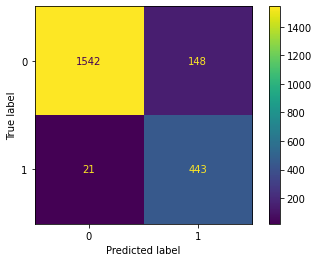

In [17]:
classifier = MultinomialNB()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
process_split(data.text, train_indxs, test_indxs, classifier, vectorizer, True)


[0.9242 0.8935 0.9004 0.9004 0.9032] 0.9043
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1690
           1       0.97      0.89      0.93       464

    accuracy                           0.97      2154
   macro avg       0.97      0.94      0.95      2154
weighted avg       0.97      0.97      0.97      2154



0.9093076664879496

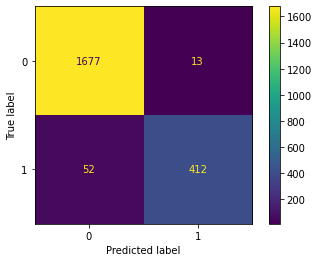

In [18]:
classifier = RandomForestClassifier()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
process_split(data.text, train_indxs, test_indxs, classifier, vectorizer, True)


[0.9298 0.8936 0.9298 0.9256 0.9088] 0.9175
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1690
           1       0.97      0.91      0.94       464

    accuracy                           0.97      2154
   macro avg       0.97      0.95      0.96      2154
weighted avg       0.97      0.97      0.97      2154



0.9220510479841632

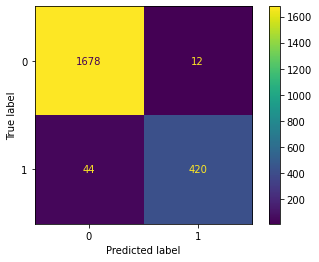

In [19]:
classifier = SVC()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
process_split(data.text, train_indxs, test_indxs, classifier, vectorizer, True)

Расширение датасета дало совсем маленький буст, но результат, особенно в сравнении с бейзлайном кажется уже досточно хорошим. Дальше можно было провести еще тюнинг параметров, но я не успел, честно говоря.